In [1]:
import numpy as np
import scipy.constants
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime
import math
import h5py
import os
import bisect

import CDOconcat

from DREAM.DREAMOutput import DREAMOutput
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.animation import FuncAnimation
from IPython import display
plt.rcParams.update({'font.size': 16})
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['image.cmap'] = 'inferno'
#%matplotlib ipympl

def basic_1D(figsize=[8,4], ydata=None, xdata=None, ylabel=None, xlabel=None, 
             title=None, yscale="linear", ymin=None, ymax=None, savename=None,
             plotfoldername=None):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(xdata, ydata, drawstyle="steps-mid", linewidth=2)
    axes = plt.gca()
    axes.set_yscale(yscale)
    axes.set_ylim([ymin, ymax])
    axes.set_ylabel(ylabel)
    axes.set_xlabel(xlabel)
    axes.grid()
    plt.title(title)
    
    if savename:
        now = datetime.datetime.now()
        date_time = now.strftime("_%Y-%m-%d_%Hh-%Mm-%Ss")
        plt.savefig(plotfoldername + savename + date_time + ".png", dpi=150)
        plt.close(fig)
    
        
def basic_2D(figsize=[8,4], xgrid=None, ygrid=None, savename=None, 
             title=None, cbarlabel=None, plotfoldername=None, ymin=None, ymax=None,
             normalization="lin", linthresh=1e-2, data=None, xlabel=None, ylabel=None,
             datamin=None, datamax=None, logdiff=None, levels=None, cmap=None):

    if data.max() < 0 and datamax is None:
        print("Warning! Datamax < 0, switching to symlog")
        normalization = "symlog"
    
    data[data > 1e308] = 0
    data[data == float('+inf')] = 0
    
    if datamax is None:
        datamax = data.max()
    
    if datamin is None:
        datamin = data.min()

    if levels is None:
        levels = 11
        
    if cmap is None:
        cmap = plt.colormaps['inferno']
        
    fig = plt.figure(figsize=figsize)
    
    if normalization == "log":
        if logdiff is None:
            ld = math.log10(datamax) - 1
            if ld > 10:
                logdiff = ld
            else:
                logdiff = 10
        
        logmax = math.ceil(np.log10(datamax))
        logmin = logmax - logdiff
        numofticks = logdiff
        div = logdiff // numofticks
        power = np.arange((logmax - (numofticks * div)), logmax, div)
        array = np.zeros(len(power)) + 10.
        ticks = np.power(array, power)
        levels1 = np.logspace(logmin, logmax, levels, base=10.0)
        formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
        norm = matplotlib.colors.LogNorm(vmin=10 ** (logmin), vmax=datamax)
        plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)
        cbar = plt.colorbar(ticks=ticks, format=formatter)
        cbar.formatter = matplotlib.ticker.LogFormatterExponent(base=10)
        cbar.update_ticks()
    elif normalization == "lin":
        plot = plt.contourf(xgrid, ygrid, data, levels=levels, cmap=cmap, vmin=datamin, vmax=datamax)
        cbar = plt.colorbar()
    elif normalization == "symlog":
        norm = matplotlib.colors.SymLogNorm(linthresh=linthresh)
        plot = plt.contourf(xgrid, ygrid, data, levels=levels, norm=norm, cmap=plt.colormaps['RdBu'])
        cbar = plt.colorbar()

    axes = plt.gca()
    axes.set_facecolor('black')
    cbar.set_label(cbarlabel)
    axes.set_ylim(ymin, ymax)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    if savename:
        now = datetime.datetime.now()
        date_time = now.strftime("_%Y-%m-%d_%Hh-%Mm-%Ss")
        plt.savefig(plotfoldername + savename + date_time + ".png", dpi=150)
        plt.close(fig)
    
    return plot, cbar

def calculate_indices(timegrid, start, ms_step):
    i = bisect.bisect_left(timegrid, start)
    if i >= len(timegrid):
        i = len(timegrid) - 1
    elif i and timegrid[i] - start > start - timegrid[i - 1]:
        i = i - 1
    else:
        i = 0
        
    frames = []
    frames.append(i) 
    
    current_time = timegrid[i] + ms_step 
    j = i
    while i < len(timegrid):
        i = bisect.bisect_left(timegrid, current_time, lo=j)
        if i >= len(timegrid):
            i = len(timegrid) - 1
        elif i and timegrid[i] - current_time > current_time - timegrid[i - 1]:
            i = i - 1
            
        frames.append(i)
        current_time += ms_step
        j = i
        i += 1

    return frames

    
def update_RE(frame, *fargs):
    """
    fargs[0] - at_radial_cell
    fargs[1] - from_momentum_cell
    fagrs[2] - to_momentum_cell
    fargs[3] - data
    fargs[4] - axes
    fargs[5] - cbar
    """
    data_to_plot = fargs[3].f_re[frame, fargs[0], :, fargs[1]:fargs[2]]
    vmin = 1e7

    if data_to_plot.max() < 1e14:
        vmax = 1e14
    else:
        vmax = data_to_plot.max()
        
    axes = fargs[4]
    data = fargs[3]
    
    pcm = axes.pcolormesh(data.re_momentumgrid[fargs[1]:fargs[2]], 
                          data.re_pitchgrid_degrees, data_to_plot, 
                          norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                          cmap=plt.colormaps['inferno'])
    
    fargs[5].update_normal(pcm)
    axes.set_title("Momentum and pitch distribution of electrons\nt=" 
                   + '{0:.1f}'.format(np.round(data.timegrid_ms[frame], 1))
                   + "ms r=" + '{0:.3f}'.format(np.round(data.radialgrid[fargs[0]], 3)) + "m")
    
    return pcm,
    
    
def animate_RE(data, at_radial_cell, plotfoldername, from_time_ms=0, every_n_ms=5, 
              from_momentum_cell=0, to_momentum_cell=-1, figsize=[10, 5]):
    fig, axes = plt.subplots(figsize=figsize)
    pcm = axes.pcolormesh(np.zeros((2,2)), norm=colors.LogNorm(vmin=1e7, vmax=1e14), 
                          cmap=plt.colormaps['inferno'])
    
    axes.set_facecolor('black')
    axes.tick_params(axis='y', which='major', bottom=False)
    axes.set_xlim(data.re_momentumgrid[from_momentum_cell + 1], 
                  data.re_momentumgrid[to_momentum_cell])
    
    cbar = plt.colorbar(pcm, ax=axes, label=r"Electron distribution [1/m$^3$]")
    cbar.ax.minorticks_on()
    axes.set_ylabel(r"Pitch angle [degrees]")
    axes.set_xlabel(r"Momentum normalized to $m_ec$ [-]")
    axes.set_title("Momentum and pitch distribution of electrons\nt=" 
                   + "0ms r=" + '{0:.3f}'.format(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
    
    frames = calculate_indices(data.timegrid_ms, from_time_ms, every_n_ms)
    fargs = (at_radial_cell, from_momentum_cell, to_momentum_cell, data, axes, cbar)
    
    animation = FuncAnimation(fig, update_RE, frames=frames, fargs=fargs, 
                              interval=500, repeat_delay=1000, blit=True)
    
    video_path = "animation_" + '{0:.3f}'.format(np.round(data.radialgrid[at_radial_cell], 3)) + "m"
    while os.path.exists(plotfoldername + video_path + ".mp4"):
        video_path += "_alt"
        
    animation.save(plotfoldername + video_path + ".mp4", writer='ffmpeg')
    plt.close(fig)
    
    
def update_RE_avg(frame, *fargs):
    """
    fargs[0] - at_radial_cell
    fargs[1] - from_momentum_cell
    fagrs[2] - to_momentum_cell
    fargs[3] - data
    fargs[4] - axes
    """
    data_to_plot = fargs[3].f_re_avg[frame, fargs[0], fargs[1]:fargs[2]]
    
    if data_to_plot.max() < 1e14:
        vmax = 1e14
    else:
        vmax = data_to_plot.max()
        
    axes = fargs[4]
    data = fargs[3]
    
    line = fargs[5] 
    line.set_data(data.re_momentumgrid[fargs[1]:fargs[2]], data_to_plot)

    axes.set_title("Momentum and pitch distribution of electrons\nt=" 
                   + '{0:.1f}'.format(np.round(data.timegrid_ms[frame], 1))
                   + "ms r=" + '{0:.3f}'.format(np.round(data.radialgrid[fargs[0]], 3)) + "m")
    
    axes.set_ylim(1e7, vmax)
    
    return line,
    
    
def animate_RE_avg(data, at_radial_cell, plotfoldername, from_time_ms=0, every_n_ms=5, 
                   from_momentum_cell=0, to_momentum_cell=-1, figsize=[10, 5]):
    fig, axes = plt.subplots(figsize=figsize)
    line, = axes.plot([0, 1], [0, 1])
    
    axes.set_facecolor('white')
    # axes.tick_params(axis='y', which='major', bottom=False)
    axes.set_xlim(data.re_momentumgrid[from_momentum_cell + 1], 
                  data.re_momentumgrid[to_momentum_cell])
    
    axes.set_ylabel(r"Electron distribution [1/m$^3$]")
    axes.set_xlabel(r"Momentum normalized to $m_ec$ [-]")
    axes.set_title("Momentum distribution of electrons\nt=" 
                   + "0ms r=" + '{0:.3f}'.format(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
    axes.set_ylim(1e7, 1e14)
    axes.set_yscale("log")
    
    frames = calculate_indices(data.timegrid_ms, from_time_ms, every_n_ms)
    fargs = (at_radial_cell, from_momentum_cell, to_momentum_cell, data, axes, line)
    
    animation = FuncAnimation(fig, update_RE_avg, frames=frames, fargs=fargs, 
                              interval=500, repeat_delay=1000, blit=True)
    
    video_path = "angle_avg_" + '{0:.3f}'.format(np.round(data.radialgrid[at_radial_cell], 3)) + "m"
    while os.path.exists(plotfoldername + video_path + ".mp4"):
        video_path += "_alt"
        
    animation.save(plotfoldername + video_path + ".mp4", writer='ffmpeg')
    plt.close(fig)
    
    
def update_full_avg(frame, *fargs):
    """
    fargs[0] - at_radial_cell
    fargs[1] - from_momentum_cell
    fagrs[2] - to_momentum_cell
    fargs[3] - data
    fargs[4] - axes
    """
    data_to_plot = fargs[3].f_full_avg[frame, fargs[0], fargs[1]:fargs[2]]
    
    if data_to_plot.max() < 1e14:
        vmax = 1e14
    else:
        vmax = data_to_plot.max()
        
    axes = fargs[4]
    data = fargs[3]
    
    line = fargs[5] 
    line.set_data(data.full_momentumgrid[fargs[1]:fargs[2]], data_to_plot)

    axes.set_title("Momentum and pitch distribution of electrons\nt=" 
                   + '{0:.1f}'.format(np.round(data.timegrid_ms[frame], 1))
                   + "ms r=" + '{0:.3f}'.format(np.round(data.radialgrid[fargs[0]], 3)) + "m")
    
    axes.set_ylim(1e4, vmax)
    
    return line,
    
    
def animate_full_avg(data, at_radial_cell, plotfoldername, from_time_ms=0, every_n_ms=5, 
                   from_momentum_cell=0, to_momentum_cell=-1, figsize=[10, 5]):
    fig, axes = plt.subplots(figsize=figsize)
    line, = axes.plot([0, 1], [0, 1])
    
    axes.set_facecolor('white')
    # axes.tick_params(axis='y', which='major', bottom=False)
    axes.set_xlim(data.full_momentumgrid[from_momentum_cell + 1], 
                  data.full_momentumgrid[to_momentum_cell])
    
    axes.set_ylabel(r"Electron distribution [1/m$^3$]")
    axes.set_xlabel(r"Momentum normalized to $m_ec$ [-]")
    axes.set_title("Momentum distribution of electrons\nt=" 
                   + "0ms r=" + '{0:.3f}'.format(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
    axes.set_ylim(1e4, 1e14)
    axes.set_yscale("log")
    
    frames = calculate_indices(data.timegrid_ms, from_time_ms, every_n_ms)
    fargs = (at_radial_cell, from_momentum_cell, to_momentum_cell, data, axes, line)
    
    animation = FuncAnimation(fig, update_full_avg, frames=frames, fargs=fargs, 
                              interval=500, repeat_delay=1000, blit=True)
    
    video_path = "full_avg_" + '{0:.3f}'.format(np.round(data.radialgrid[at_radial_cell], 3)) + "m"
    while os.path.exists(plotfoldername + video_path + ".mp4"):
        video_path += "_alt"
        
    animation.save(plotfoldername + video_path + ".mp4", writer='ffmpeg')
    plt.close(fig)

    
def newest_output(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files if (basename.endswith('.h5') and basename.startswith('output_'))]
    return max(paths, key=os.path.getmtime)


def calculate_indices2(timegrid, start, number):
    i = bisect.bisect_left(timegrid, start)
    if i >= len(timegrid):
        i = len(timegrid) - 1
    elif i and timegrid[i] - start > start - timegrid[i - 1]:
        i = i - 1
    else:
        i = 0
        
    frames = []
    frames.append(i) 
    
    ms_step = (timegrid[-1] - timegrid[i]) / number
    current_time = timegrid[i] + ms_step 
    j = i
    while i < len(timegrid):
        i = bisect.bisect_left(timegrid, current_time, lo=j)
        if i >= len(timegrid):
            i = len(timegrid) - 1
        elif i and timegrid[i] - current_time > current_time - timegrid[i - 1]:
            i = i - 1
            
        frames.append(i)
        current_time += ms_step
        j = i
        i += 1

    return frames


In [2]:
folder = "C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/no_Ar_no_recycl/"
diff = "30"

fnames = []
try:
    newest = newest_output(folder)
    #newest = "C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/no_Ar/output_21_.h5"
    numoffiles = int(newest.split("_")[-2])
except:
    print("Finding newest output unsuccesful")
    
for i in range(1, numoffiles + 1):
    fname = folder + "output_" + str(i) + "_.h5"
    fnames.append(fname)
    
concat = CDOconcat.CustomConcat(fnames)
endtime = '{0:.0f}'.format(concat.timegrid_ms[-1])
print(endtime)
concat.info()

density_D_0 = concat.n_i[:, 0, :]
density_D_1 = concat.n_i[:, 1, :]
density_T_0 = concat.n_i[:, 2, :]
density_T_1 = concat.n_i[:, 3, :]
density_Ar = concat.n_i[:, 4:, :]

plotfoldername = folder + "plots_" + endtime + "/"
if os.path.exists(plotfoldername):
    pass
else:
    os.mkdir(plotfoldername)

animfoldername = folder + "vids_" + endtime + "/"
if os.path.exists(animfoldername):
    pass
else:
    os.mkdir(animfoldername)

201
Simulation time from 0.001 ms to 201.01 ms
Minor radius: [2.93] m
Number of radial grid cells: 20
Radial step (dr): 0.14650000000000002 m
Hottailgrid enabled: True
Resolution: (100, 1)
Runawaygrid enabled: True
Resolution: (180, 15)


In [11]:
if True:
    indices = calculate_indices(timegrid=concat.timegrid_ms, start=10, ms_step=40)
    indices = indices[1:-1]
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = concat.T_cold
    fig = plt.figure(figsize=(8, 5.5))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, :], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 0))+" ms")
        j += 1
        
    #plt.axvline(x = 2.7, color = 'magenta', label = 'pMax_hot')

    plt.ylabel(r'Electron temperature [eV]')
    plt.xlabel(r'Minor radius [m]')
    #plt.title("Center")
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e-1, None)
    plt.xlim(0, None)
    #plt.yscale("log")
    plt.legend()
    plt.grid()


    savename = "T_cold_LINE_"
    while os.path.exists(plotfoldername + savename + ".png"):
        savename += "_alt"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)

In [10]:
if True:
    indices = [200, 500, 1000, -1]
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = concat.full_momentumgrid
    ydata = concat.f_full_avg[:, 0, :]
    fig = plt.figure(figsize=(8, 5.5))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, :], label='{0:.3f}'.format(np.round(concat.timegrid_ms[i], 3))+" ms", color=ccolors[j])
        j += 1
        
    plt.axvline(x = 2.7, color = 'magenta', label = 'pMax_hot')

    plt.ylabel(r'Angle averaged electron distribution [m$^{-3}$]')
    plt.xlabel(r'Momentum normalized to m$_e$c')
    plt.title("Center")
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e-5, None)
    plt.xlim(0, 20)
    plt.yscale("log")
    plt.legend()
    plt.grid()


    savename = ("f_hot_" + diff + "_center")
    while os.path.exists(plotfoldername + savename + ".png"):
        savename += "_alt"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)

(<matplotlib.contour.QuadContourSet at 0x2e752d2d450>,
 <matplotlib.colorbar.Colorbar at 0x2e752d21bd0>)

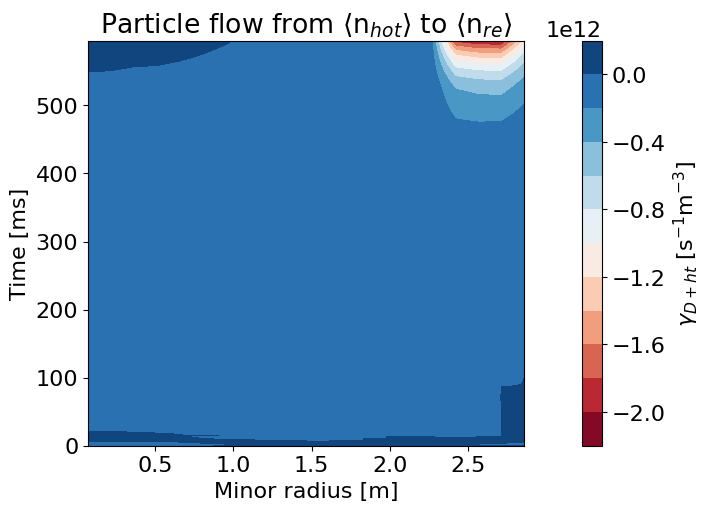

In [6]:
    basic_2D(figsize=[7,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename=None, 
             title=r"Particle flow from $\langle$n$_{hot}\rangle$ to $\langle$n$_{re}\rangle$", 
             cbarlabel=r"$\gamma_{D+ht}$ [s$^{-1}$m$^{-3}$]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="symlog", linthresh=5e15, data=concat.flux_to_RE, 
             xlabel="Minor radius [m]", ylabel="Time [ms]",
             cmap=plt.colormaps['seismic'])

In [13]:
if True:
    animate_full_avg(concat, 0, animfoldername, from_time_ms=0, every_n_ms=2, 
                     from_momentum_cell=0, to_momentum_cell=70, figsize=[12, 6])

In [6]:
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="log_ratio_E_to_Eceff", 
             title=r"Logarithm of E/E$_{c, eff}$", cbarlabel=r"log$_{10}$(E/E$_{c, eff}$) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.E_field/concat.Eceff, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=2, levels=5, cmap=plt.colormaps['plasma'])

(<matplotlib.contour.QuadContourSet at 0x1e884602710>,
 <matplotlib.colorbar.Colorbar at 0x1e883e75d10>)

In [7]:
current_threshold = 2e5
# index = next(i for i, v in enumerate(concat.I_re) if v > current_threshold)
index = 100
re_current_start_ms = concat.timegrid_ms[index]
from_time_ms = int(re_current_start_ms) - (int(re_current_start_ms) % 5)
# print("RE current reaches 200 kA at: " + '{:.2f}'.format(re_current_start_ms) + " ms")
print("start animations from: " + str(from_time_ms) + " ms")

animations = False
figures = True
distributions = False
argon = False

if figures:
    basic_2D(figsize=[6,4], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_Z0", 
             title="Deuterium density Z=0", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=density_D_0, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17)
    basic_2D(figsize=[6,4], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_Z0_zoom", 
             title="Deuterium density Z=0", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=150,
             normalization="log", data=density_D_0, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17)
    basic_2D(figsize=[6,4], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_Z1", 
             title="Deuterium density Z=1", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=density_D_1, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17)
    basic_2D(figsize=[6,4], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_Z1_zoom", 
             title="Deuterium density Z=1", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=150,
             normalization="log", data=density_D_1, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17)
    basic_2D(figsize=[6,4], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_total", 
             title="Deuterium density Z=0, 1", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=density_D_0 + density_D_1, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17)
    
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="W_cold", 
             title="Cold electron energy density", cbarlabel=r"log$_{10}$(W$_{cold}$/(J/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.W_cold, xlabel=None, ylabel=None,
             datamin=None, datamax=None, logdiff=5, levels=16)
    
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_tot", 
             title="Total current density", cbarlabel=r"log$_{10}$(j$_{tot}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.j_tot, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=3, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_re", 
             title="RE current density", cbarlabel=r"log$_{10}$(j$_{RE}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.j_re, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=3, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_ohm", 
             title="Ohmic current density", cbarlabel=r"log$_{10}$(j$_{ohm}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.j_ohm, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=3, levels=16)
    
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="T_cold_full", 
             title="Electron temperature", cbarlabel=r"log$_{10}$(T$_{cold}$/(1eV)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.T_cold, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=5, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="T_cold_zoomed", 
             title="Electron temperature", cbarlabel=r"log$_{10}$(T$_{cold}$/(1eV)) [-]", 
             plotfoldername=plotfoldername, ymax=75,
             normalization="log", data=concat.T_cold, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=5, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="T_cold_LIN", 
             title="Electron temperature", cbarlabel=r"T$_{cold}$ [eV]", 
             plotfoldername=plotfoldername, ymin=from_time_ms, ymax=None,
             normalization="lin", data=concat.T_cold, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=5, levels=16)
    
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="E_field_lin", 
             title="Electric field", cbarlabel=r"E [V/m]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="lin", data=concat.E_field, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=3, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="log_ratio_E_to_Eceff", 
             title=r"Logarithm of E/E$_{c, eff}$", cbarlabel=r"log$_{10}$(E/E$_{c, eff}$) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.E_field/concat.Eceff, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=2, levels=19, cmap=plt.colormaps['plasma'])
    
if figures:
    fig = plt.figure(figsize=(8, 6))
    plt.subplot(1, 1, 1)  # rows, columns, index
    # For example fig.add_subplot(3, 1, (1, 2)) makes a subplot that spans the upper 2/3 of the figure

    plt.plot(concat.timegrid * 1000, concat.I_p / 1e6, label=r"I$_p$")
    plt.plot(concat.timegrid * 1000, (concat.I_re + concat.I_hot) / 1e6, label=r"I$_{RE}$")
    plt.plot(concat.timegrid * 1000, concat.I_wall / 1e6, label=r"I$_{wall}$")
    plt.plot(concat.timegrid * 1000,  concat.I_ohm / 1e6, linestyle="--", label=r"I$_{ohm}$")
    plt.plot(concat.timegrid * 1000,  concat.I_hot / 1e6, label=r"I$_{hot}$")

    plt.ylabel('Currents [MA]')
    plt.xlabel('Time [ms]')
    plt.title("D=" + diff + r" m$^2$/s; RE grid resolution " + str(concat.runawaygrid_dimensions) 
              + r"; p$_{max}$=" + '{0:.0f}'.format(np.round(concat.re_momentumgrid_edges[-1], 0)))
    plt.tick_params('x', labelbottom=True)

    plt.ylim(0, 18)
    plt.legend()
    plt.grid()

    savename = "currents_"
    savename += "diff_" + diff + "_REgrid_" + str(concat.runawaygrid_dimensions) + "_pMax_" 
    savename += '{0:.0f}'.format(np.round(concat.re_momentumgrid_edges[-1], 0))

    while os.path.exists(plotfoldername + savename + ".png"):
        savename += "_alt"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)
    
if distributions:
    indices = calculate_indices2(concat.timegrid_ms, from_time_ms + 20, 8)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = concat.re_momentumgrid
    
    for r in range(len(concat.radialgrid)):
        ydata = concat.f_re_avg[:, r]
        fig = plt.figure(figsize=(8, 5))
        plt.subplot(1, 1, 1)  # rows, columns, index
        j = 0
        for i in indices:
            plt.plot(xdata, ydata[i], label='{0:.1f}'.format(np.round(concat.timegrid_ms[i], 1))+" ms", color=ccolors[j])
            j += 1

        plt.ylabel(r'Angle averaged distribution [m$^{-3}$]')
        plt.xlabel(r'p$_{||}$')
        plt.title("D=" + diff + r" m$^2$/s; resolution " + str(concat.runawaygrid_dimensions) 
                  + "; r=" + '{0:.3f}'.format(np.round(concat.radialgrid[r], 3)) + "m")
        plt.tick_params('x', labelbottom=True)

        plt.ylim(1e7, 1e14)
        plt.yscale("log")
        plt.legend()
        plt.grid()


        savename = ("f_re_avg_diff_" + diff + "_REgrid_" + str(concat.runawaygrid_dimensions) 
                    +"_r_" + '{0:.3f}'.format(np.round(concat.radialgrid[r], 3)) + "m")
        while os.path.exists(plotfoldername + savename + ".png"):
            savename += "_alt"

        plt.savefig(plotfoldername + savename + ".png", dpi=150)
        plt.close(fig)
        
if figures:
    indices = calculate_indices2(concat.timegrid_ms, from_time_ms + 20, 6)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = concat.n_re
    fig = plt.figure(figsize=(8, 5))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, :], label='{0:.1f}'.format(np.round(concat.timegrid_ms[i], 1))+" ms", color=ccolors[j])
        j += 1

    plt.ylabel(r'Runaway electron density [m$^{-3}$]')
    plt.xlabel(r'Minor radius [m]')
    plt.title("D=" + diff + r" m$^2$/s; resolution " + str(concat.runawaygrid_dimensions))
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e14, None)
    plt.yscale("log")
    plt.legend()
    plt.grid()


    savename = ("n_re_" + diff + "_REgrid_" + str(concat.runawaygrid_dimensions))
    while os.path.exists(plotfoldername + savename + ".png"):
        savename += "_alt"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)
    
if figures:
    indices = calculate_indices2(concat.timegrid_ms, from_time_ms + 20, 6)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = concat.j_re
    fig = plt.figure(figsize=(8, 5))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, :], label='{0:.1f}'.format(np.round(concat.timegrid_ms[i], 1))+" ms", color=ccolors[j])
        j += 1

    plt.ylabel(r'RE current density [A/m$^{2}$]')
    plt.xlabel(r'Minor radius [m]')
    plt.title("D=" + diff + r" m$^2$/s; resolution " + str(concat.runawaygrid_dimensions))
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e4, None)
    plt.yscale("log")
    plt.legend()
    plt.grid()


    savename = ("j_re_" + diff + "_REgrid_" + str(concat.runawaygrid_dimensions))
    while os.path.exists(plotfoldername + savename + ".png"):
        savename += "_alt"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)
    
if figures:
    indices = calculate_indices2(concat.timegrid_ms, 0, 8)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = concat.j_tot
    fig = plt.figure(figsize=(8, 5))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, :], label='{0:.1f}'.format(np.round(concat.timegrid_ms[i], 1))+" ms", color=ccolors[j])
        j += 1

    plt.ylabel(r'Total current density [A/m$^{2}$]')
    plt.xlabel(r'Minor radius [m]')
    plt.title("D=" + diff + r" m$^2$/s; RE grid resolution " + str(concat.runawaygrid_dimensions))
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e4, None)
    plt.yscale("log")
    plt.legend()
    plt.grid()


    savename = ("j_tot_" + diff + "_REgrid_" + str(concat.runawaygrid_dimensions))
    while os.path.exists(plotfoldername + savename + ".png"):
        savename += "_alt"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)
    
if argon:
    g_time = len(concat.timegrid)
    g_r = len(concat.radialgrid)
    avg_Ar_ionization = np.zeros((g_time, g_r))

    temp1 = 0  # weighted sum
    temp2 = 0  # simple sum of all argon atoms

    for i in range(g_time):
        for j in range(19):
            temp1 += j * density_Ar[i, j, :] * concat.real_volumes_of_cells
            temp2 += density_Ar[i, j, :] * concat.real_volumes_of_cells

        avg_Ar_ionization[i] = temp1 / temp2
    
    basic_2D(figsize=[7,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Ar_avg_Z", 
             title="Average ionization level of Ar", cbarlabel=r"Z$_{avg}$(Ar)", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="lin", data=avg_Ar_ionization, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=8, levels=33, cmap=plt.colormaps['plasma'])
    
if figures:
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="gamma_Dreicer", 
             title=r"Dreicer runaway rate", cbarlabel=r"log$_{10}$($\gamma_{Dreicer}$/(s$^{-1}$m$^{-3}$)) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="log", data=concat.gammaDreicer, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=5, levels=16, cmap=plt.colormaps['plasma'])
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="gamma_Compton", 
             title="Compton runaway rate (ITER!)", cbarlabel=r"log$_{10}$($\gamma_{Compton}$/(s$^{-1}$m$^{-3}$)) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="log", data=concat.gammaCompton, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17, cmap=plt.colormaps['plasma'])
    # basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="gamma_Tritium", 
    #          title="Tritium runaway rate", cbarlabel=r"log$_{10}$($\gamma_{T}$/(s$^{-1}$m$^{-3}$)) [-]", 
    #          plotfoldername=plotfoldername, ymin=0, ymax=None,
    #          normalization="log", data=concat.gammaTritium, xlabel="Minor radius [m]", ylabel="Time [ms]",
    #          datamin=None, datamax=None, logdiff=4, levels=17, cmap=plt.colormaps['plasma'])
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="gamma_Ava", 
             title="Avalanche runaway rate", cbarlabel=r"log$_{10}$($\gamma_{ava}$/(s$^{-1}$m$^{-3}$)) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="log", data=concat.gammaAva * concat.n_re, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=13, levels=27, cmap=plt.colormaps['plasma'])
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="fre_coll_pow_dens", 
             title="Collisional heating \npower density by REs", cbarlabel=r"PD$_{coll}$ [MWm$^{-3}$]", 
             plotfoldername=plotfoldername, ymin=None, ymax=None,
             normalization="lin", linthresh=1e-2, data=abs(concat.Tcold_fre_coll) / 1e6, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=None, levels=119, cmap=plt.colormaps['plasma'])
        
if animations:
    for i in range(len(concat.radialgrid)):
        animate_RE(concat, i, animfoldername, from_time_ms=from_time_ms, every_n_ms=5, 
                   from_momentum_cell=0, to_momentum_cell=-1, figsize=[10, 6])
        animate_RE_avg(concat, i, animfoldername, from_time_ms=from_time_ms, every_n_ms=5, 
                       from_momentum_cell=0, to_momentum_cell=-1, figsize=[10, 6])

start animations from: 0 ms


C:\Users\lefer\AppData\Local\Temp\ipykernel_3216\3898651213.py:91: UserWarning: Log scale: values of z <= 0 have been masked
  plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)


In [8]:
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Tcold_ohmic", 
             title="Ohmic power density", cbarlabel=r"log$_{10}$(P$_{ohm}$/(W/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=-concat.Tcold_ohmic, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=3, levels=16)

(<matplotlib.contour.QuadContourSet at 0x1e88463a010>,
 <matplotlib.colorbar.Colorbar at 0x1e883f33a10>)

In [ ]:
if argon:
    g_time = len(concat.timegrid)
    g_r = len(concat.radialgrid)
    avg_Ar_ionization = np.zeros((g_time, g_r))

    temp1 = 0  # weighted sum
    temp2 = 0  # simple sum of all argon atoms

    for i in range(g_time):
        for j in range(19):
            temp1 += j * density_Ar[i, j, :] * concat.real_volumes_of_cells
            temp2 += density_Ar[i, j, :] * concat.real_volumes_of_cells

        avg_Ar_ionization[i] = temp1 / temp2
    
    basic_2D(figsize=[7,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename=None, 
             title="Average ionization level of Ar", cbarlabel=r"Z$_{avg}$(Ar)", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="lin", data=avg_Ar_ionization, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=8, levels=33, cmap=plt.colormaps['plasma'])

In [9]:
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="fre_coll_pow_dens", 
             title="Collisional heating \npower density by REs", cbarlabel=r"PD$_{coll}$ [Wm$^{-3}$]", 
             plotfoldername=plotfoldername, ymin=None, ymax=None,
             normalization="lin", linthresh=1e-2, data=abs(concat.Tcold_fre_coll), xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=None, levels=119, cmap=plt.colormaps['plasma'])

(<matplotlib.contour.QuadContourSet at 0x1e88c4e1690>,
 <matplotlib.colorbar.Colorbar at 0x1e88bef4350>)

In [32]:
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename=None, 
             title="Tritium runaway rate", cbarlabel=r"log$_{10}$($\gamma_{T}$/(s$^{-1}$m$^{-3}$)) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="log", data=abs(concat.gammaTritium), xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=10, levels=17, cmap=plt.colormaps['plasma'])

C:\Users\lefer\AppData\Local\Temp\ipykernel_11120\3898651213.py:81: RuntimeWarning: divide by zero encountered in log10
  logmax = math.ceil(np.log10(datamax))


OverflowError: cannot convert float infinity to integer

<Figure size 600x500 with 0 Axes>

In [11]:
data = concat.Tcold_radiation
xgrid = concat.radialgrid
ygrid = concat.timegrid_ms
normalization = "log"
datamax = 1e8
datamin = None
levels = None
cmap = plt.colormaps['inferno']
savename = "rad_pow_dens"
cbarlabel = r"log$_{10}$(PD$_{rad}$/(1 W/m$^{3}$)) [-]"
xlabel = "Minor radius [m]"
ylabel = "Time [ms]"
title = "Radiated power density"
ymin = None
ymax = None
logdiff = 3
linthresh = 1e11

if datamax is None:
    datamax = data.max()

if datamin is None:
    datamin = data.min()

if levels is None:
    levels = 11
    # levels = [1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8]

if cmap is None:
    cmap = plt.colormaps['inferno']

fig = plt.figure(figsize=[6,5])

if normalization == "log":
    if logdiff is None:
        ld = math.log10(datamax) - 1
        if ld > 10:
            logdiff = ld
        else:
            logdiff = 10

    logmax = 8
    logmin = 3
    numofticks = 5
    div = 1
    power = np.arange((logmax - (numofticks * div)), logmax, div)
    array = np.zeros(len(power)) + 10.
    ticks = np.power(array, power)
    levels1 = np.logspace(logmin, logmax, levels, base=10.0)
    formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
    norm = matplotlib.colors.LogNorm(vmin=10 ** (logmin), vmax=datamax)
    plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)
    cbar = plt.colorbar(ticks=ticks, format=formatter)
    cbar.formatter = matplotlib.ticker.LogFormatterExponent(base=10)
    cbar.update_ticks()
elif normalization == "lin":
    plot = plt.contourf(xgrid, ygrid, data, levels=levels, cmap=cmap)
    cbar = plt.colorbar()
elif normalization == "symlog":
    norm = matplotlib.colors.SymLogNorm(linthresh=linthresh)
    plot = plt.contourf(xgrid, ygrid, data, levels=levels, norm=norm, cmap=plt.colormaps['RdBu'])
    cbar = plt.colorbar()

axes = plt.gca()
axes.set_facecolor('black')
cbar.set_label(cbarlabel)
axes.set_ylim(ymin, ymax)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)

if True:
    now = datetime.datetime.now()
    date_time = now.strftime("_%Y-%m-%d_%Hh-%Mm-%Ss")
    plt.savefig(plotfoldername + savename + date_time + ".png", dpi=150)
    plt.close(fig)

C:\Users\lefer\AppData\Local\Temp\ipykernel_14164\876487981.py:52: UserWarning: Log scale: values of z <= 0 have been masked
  plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)


In [12]:
data = concat.Tcold_transport
xgrid = concat.radialgrid
ygrid = concat.timegrid_ms
normalization = "log"
datamax = 1e8
datamin = None
levels = None
cmap = plt.colormaps['inferno']
savename = "tr_pow_dens"
cbarlabel = r"log$_{10}$(PD$_{tr}$/(1 W/m$^{3}$)) [-]"
xlabel = "Minor radius [m]"
ylabel = "Time [ms]"
title = "Transported power density"
ymin = None
ymax = None
logdiff = 3
linthresh = 1e11

if datamax is None:
    datamax = data.max()

if datamin is None:
    datamin = data.min()

if levels is None:
    levels = 11
    # levels = [1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8]

if cmap is None:
    cmap = plt.colormaps['inferno']

fig = plt.figure(figsize=[6,5])

if normalization == "log":
    if logdiff is None:
        ld = math.log10(datamax) - 1
        if ld > 10:
            logdiff = ld
        else:
            logdiff = 10

    logmax = 8
    logmin = 3
    numofticks = 5
    div = 1
    power = np.arange((logmax - (numofticks * div)), logmax, div)
    array = np.zeros(len(power)) + 10.
    ticks = np.power(array, power)
    levels1 = np.logspace(logmin, logmax, levels, base=10.0)
    formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
    norm = matplotlib.colors.LogNorm(vmin=10 ** (logmin), vmax=datamax)
    plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)
    cbar = plt.colorbar(ticks=ticks, format=formatter)
    cbar.formatter = matplotlib.ticker.LogFormatterExponent(base=10)
    cbar.update_ticks()
elif normalization == "lin":
    plot = plt.contourf(xgrid, ygrid, data, levels=levels, cmap=cmap)
    cbar = plt.colorbar()
elif normalization == "symlog":
    norm = matplotlib.colors.SymLogNorm(linthresh=linthresh)
    plot = plt.contourf(xgrid, ygrid, data, levels=levels, norm=norm, cmap=plt.colormaps['RdBu'])
    cbar = plt.colorbar()

axes = plt.gca()
axes.set_facecolor('black')
cbar.set_label(cbarlabel)
axes.set_ylim(ymin, ymax)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)

if True:
    now = datetime.datetime.now()
    date_time = now.strftime("_%Y-%m-%d_%Hh-%Mm-%Ss")
    plt.savefig(plotfoldername + savename + date_time + ".png", dpi=150)
    plt.close(fig)

C:\Users\lefer\AppData\Local\Temp\ipykernel_14164\1232621265.py:52: UserWarning: Log scale: values of z <= 0 have been masked
  plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)


C:\Users\lefer\AppData\Local\Temp\ipykernel_14164\3898651213.py:91: UserWarning: Log scale: values of z <= 0 have been masked
  plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)
C:\Users\lefer\AppData\Local\Temp\ipykernel_14164\3898651213.py:81: RuntimeWarning: divide by zero encountered in log10
  logmax = math.ceil(np.log10(datamax))


OverflowError: cannot convert float infinity to integer

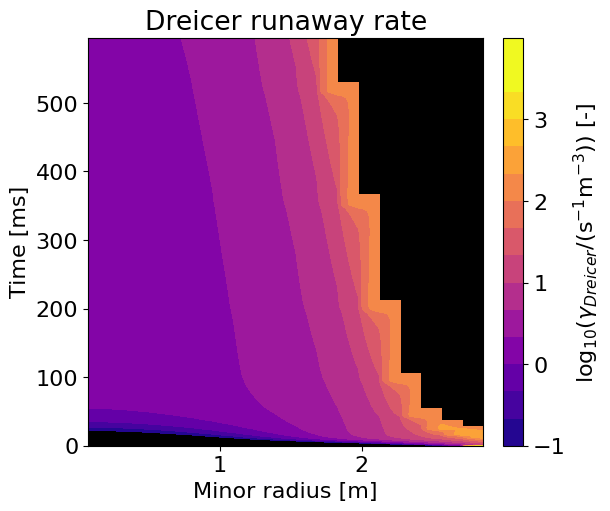

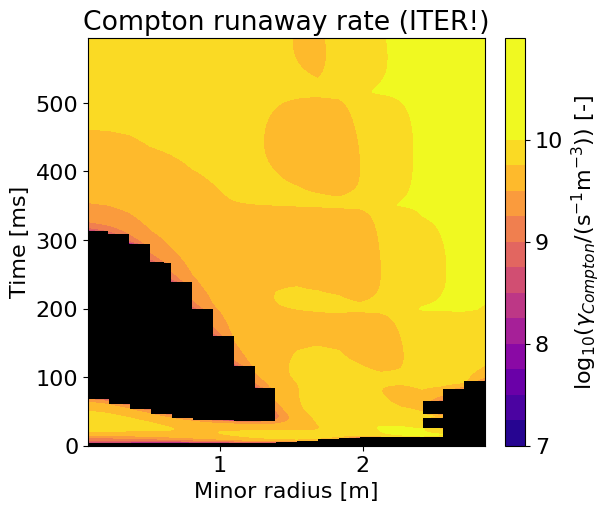

<Figure size 600x500 with 0 Axes>

In [13]:
if True:
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename=None, 
             title=r"Dreicer runaway rate", cbarlabel=r"log$_{10}$($\gamma_{Dreicer}$/(s$^{-1}$m$^{-3}$)) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="log", data=concat.gammaDreicer, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=5, levels=16, cmap=plt.colormaps['plasma'])
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename=None, 
             title="Compton runaway rate (ITER!)", cbarlabel=r"log$_{10}$($\gamma_{Compton}$/(s$^{-1}$m$^{-3}$)) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="log", data=concat.gammaCompton, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17, cmap=plt.colormaps['plasma'])
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename=None, 
             title="Tritium runaway rate", cbarlabel=r"log$_{10}$($\gamma_{T}$/(s$^{-1}$m$^{-3}$)) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="log", data=concat.gammaTritium, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17, cmap=plt.colormaps['plasma'])
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename=None, 
             title="Avalanche runaway rate", cbarlabel=r"log$_{10}$($\gamma_{ava}$/(s$^{-1}$m$^{-3}$)) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="log", data=concat.gammaAva * concat.n_re, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=13, levels=27, cmap=plt.colormaps['plasma'])

In [14]:
wall_radius = 2.96
wall_region_thickness = 0.1
wall_resistivity = 0.76e-6  # Ohm*m
walltime = scipy.constants.mu_0 * wall_radius * wall_region_thickness / wall_resistivity

print(str(np.round(walltime * 1000, 1)) + " ms")

489.4 ms
